In [1]:
# Import your libraries here
from scripts.config import settings
import requests
import pandas as pd
import sqlite3
from scripts.data import SQLRepository
from scripts.model import GarchModel
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import requests
from arch.univariate.base import ARCHModelResult

In [2]:
ticker = 'MTNOY'
output_size = 'full'
data_type = 'json'

url = (
    'https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?'
    'function=TIME_SERIES_DAILY&'
    f'symbol={ticker}&'
    f'outputsize={output_size}&'
    f'datatype={data_type}&'
    f'apikey={settings.alpha_api_key}'
)

print("url type:", type(url))
url

url type: <class 'str'>


'https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?function=TIME_SERIES_DAILY&symbol=MTNOY&outputsize=full&datatype=json&apikey=845f02986d446722fffc7861c227d957fca7c8cacdb73074bf399b56ef66cf8688ee817f8ff6ae060279ab42160d6d45c8254128e444500d5958e992003c8a3d386fc3df26d399e0dac79de698d9bffc2c96cee8198f69376c73bd09d9de5de18c19bc43b5c308bcc780fec55f81956497a33fed04782410613eb70873c75884'

In [3]:
response = requests.get(url=url)

print("response type:", type(response))

response type: <class 'requests.models.Response'>


In [4]:
response_code = response.status_code

print("code type:", type(response_code))
response_code

code type: <class 'int'>


200

In [5]:
response_data = response.json()['Time Series (Daily)']
df_mtnoy = pd.DataFrame().from_dict(response_data, orient='index', dtype=float)

df_mtnoy.index = pd.to_datetime(df_mtnoy.index)
df_mtnoy.index.name = 'date'

df_mtnoy.columns = [col.split('. ')[1] for col in df_mtnoy.columns]

print("df_mtnoy type:", type(df_mtnoy))
df_mtnoy.head()

df_mtnoy type: <class 'pandas.core.frame.DataFrame'>


,open,high,low,close,volume
date,,,,,
2022-12-30,7.595,7.595,7.4260,7.440,15149.0
2022-12-29,7.510,7.620,7.5100,7.590,41909.0
2022-12-28,7.490,7.515,7.4750,7.478,5988.0
2022-12-27,7.530,7.690,7.4125,7.650,71972.0
2022-12-23,7.230,7.800,7.2300,7.610,15976.0


In [6]:
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
connection

In [7]:
# Insert `MTNOY` data into database
repo = SQLRepository()
repo.insert_table(table_name=ticker, records=df_mtnoy, if_exists='replace')

{'records_inserted': 3896, 'transaction_successful': True}

In [8]:
df_mtnoy_read = repo.read_table(table_name=ticker)

print("df_mtnoy_read type:", type(df_mtnoy_read))
print("df_mtnoy_read shape:", df_mtnoy_read.shape)
df_mtnoy_read.head()

df_mtnoy_read type: <class 'pandas.core.frame.DataFrame'>
df_mtnoy_read shape: (3896, 5)


,open,high,low,close,volume
date,,,,,
2022-12-30,7.595,7.595,7.4260,7.440,15149.0
2022-12-29,7.510,7.620,7.5100,7.590,41909.0
2022-12-28,7.490,7.515,7.4750,7.478,5988.0
2022-12-27,7.530,7.690,7.4125,7.650,71972.0
2022-12-23,7.230,7.800,7.2300,7.610,15976.0


In [9]:
model = GarchModel(ticker=ticker, repo=repo, use_new_data=False)
model.wrangle_data(n_observations=2500)
y_mtnoy = model.data

print("y_mtnoy type:", type(y_mtnoy))
print("y_mtnoy shape:", y_mtnoy.shape)
y_mtnoy.head()

y_mtnoy type: <class 'pandas.core.series.Series'>
y_mtnoy shape: (2500,)


date
2013-01-29    0.876289
2013-01-30   -1.277466
2013-01-31    1.966874
2013-02-01    1.878173
2013-02-04    0.398605
Name: close, dtype: float64

In [10]:
mtnoy_daily_volatility = y_mtnoy.std()

print("mtnoy_daily_volatility type:", type(mtnoy_daily_volatility))
print("MTN Daily Volatility:", mtnoy_daily_volatility)

mtnoy_daily_volatility type: <class 'numpy.float64'>
MTN Daily Volatility: 2.9146336946014615


In [11]:
mtnoy_annual_volatility = mtnoy_daily_volatility * np.sqrt(252)

print("mtnoy_annual_volatility type:", type(mtnoy_annual_volatility))
print("MTN Annual Volatility:", mtnoy_annual_volatility)

mtnoy_annual_volatility type: <class 'numpy.float64'>
MTN Annual Volatility: 46.26837551258909


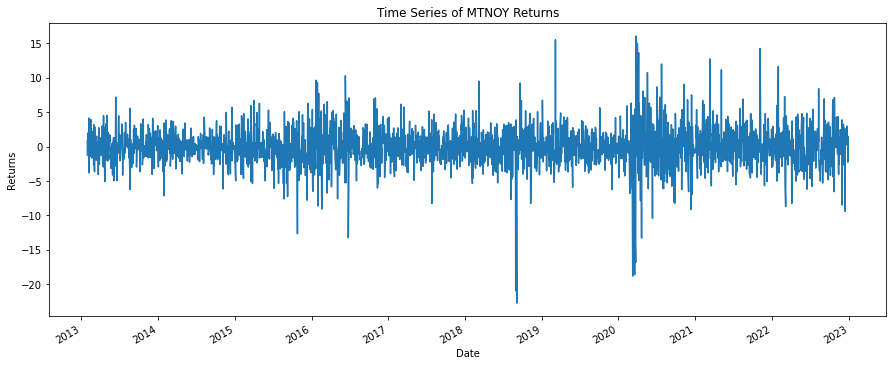

In [12]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_mtnoy` on `ax`
y_mtnoy.plot(ax=ax)

# Add axis labels
plt.xlabel('Date')
plt.ylabel('Returns')

# Add title
plt.title("Time Series of MTNOY Returns")

# Don't delete the code below 👇
plt.savefig("images/8-5-11.png", dpi=150)


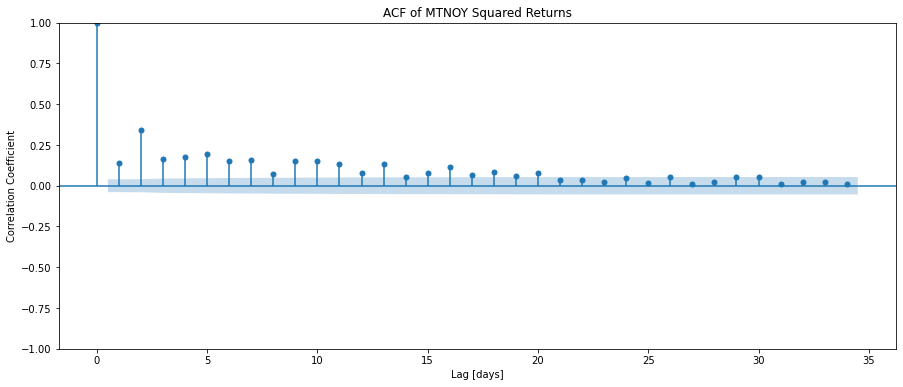

In [13]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_mtnoy ** 2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Add title
plt.title("ACF of MTNOY Squared Returns")

# Don't delete the code below 👇
plt.savefig("images/8-5-12.png", dpi=150)


C:\Users\Dar Computers\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


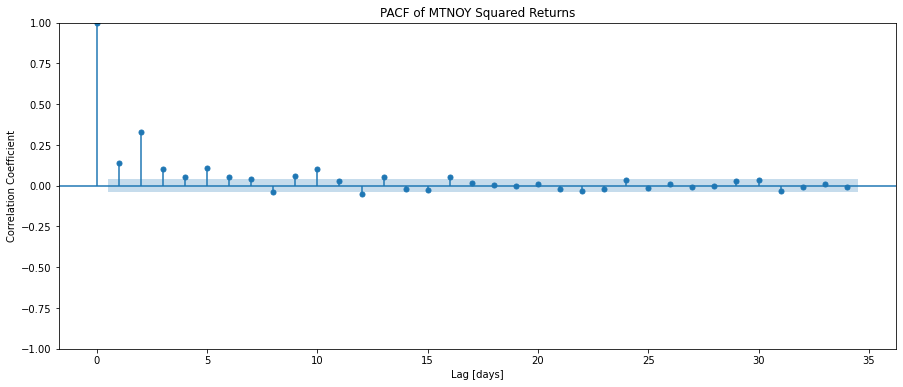

In [14]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_mtnoy ** 2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

# Add title
plt.title("PACF of MTNOY Squared Returns")

# Don't delete the code below 👇
plt.savefig("images/8-5-13.png", dpi=150)


In [15]:
y_mtnoy.name = 'return'
cutoff_test = int(len(y_mtnoy) * 0.8)
y_mtnoy_train = y_mtnoy.iloc[:cutoff_test]
y_mtnoy_train.name = 'return'

print("y_mtnoy_train type:", type(y_mtnoy_train))
print("y_mtnoy_train shape:", y_mtnoy_train.shape)
y_mtnoy_train.head()

y_mtnoy_train type: <class 'pandas.core.series.Series'>
y_mtnoy_train shape: (2000,)


date
2013-01-29    0.876289
2013-01-30   -1.277466
2013-01-31    1.966874
2013-02-01    1.878173
2013-02-04    0.398605
Name: return, dtype: float64

In [16]:
# Build and train model
model_obj = model
model_obj.fit(p=1, q=1)
model = model_obj.model

print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5999.13
Distribution:                  Normal   AIC:                           12006.3
Method:            Maximum Likelihood   BIC:                           12029.6
                                        No. Observations:                 2500
Date:                Sun, Jan 01 2023   Df Residuals:                     2499
Time:                        16:30:50   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0148  4.995e-02      0.296      0.767 [-8.312e-02,  0.113]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1152  6.218e-02      1.853  6.391e-02  [-6.661e-03,  0.237]
alpha[1]       0.0585  1.715e-02      3.414  6.400e-04 [2.493e-02,9.214e-02]
beta[1]        0.9293  2.103e-02     44.193      0.000     [  0.888,  0.971]
============================================================================

Covariance estimator: robust
"""

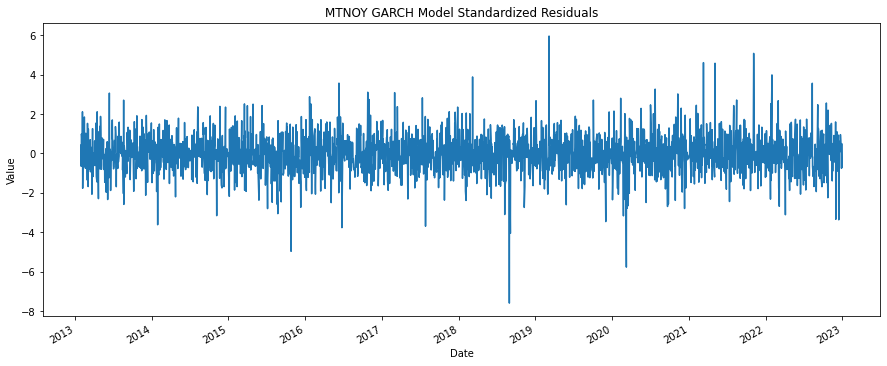

In [17]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax)

# Add axis labels
plt.xlabel('Date')
plt.ylabel('Value')

# Add title
plt.title('MTNOY GARCH Model Standardized Residuals')

# Don't delete the code below 👇
plt.savefig("images/8-5-16.png", dpi=150)


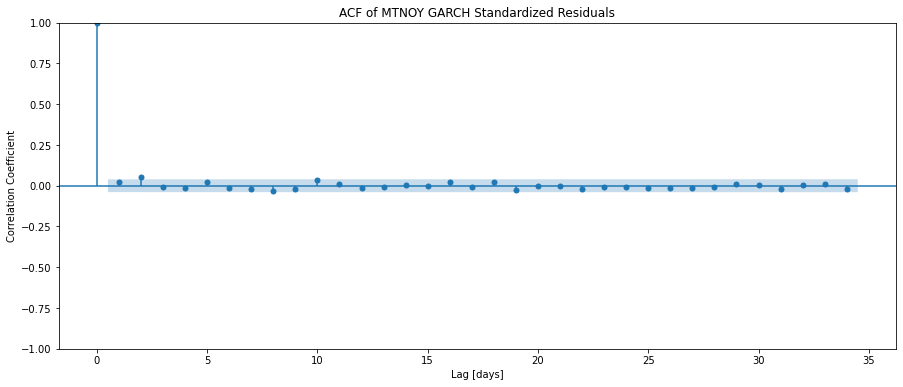

In [18]:
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid ** 2, ax=ax)

# Add axis labels
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')

# Add title
plt.title('ACF of MTNOY GARCH Standardized Residuals')

# Don't delete the code below 👇
plt.savefig("images/8-5-17.png", dpi=150)


In [19]:
# Import `build_model` function
from main import build_model

# Build model using new `MTNOY` data
model = build_model(ticker="MTNOY", use_new_data=True)

# Wrangle `MTNOY` returns
model.wrangle_data(n_observations=2500)

# Fit GARCH(1,1) model to data
model.fit(p=1, q=1)

# Does model have AIC and BIC attributes?
assert hasattr(model, "aic")
assert hasattr(model, "bic")

In [20]:
# Import `FitIn` class and `fit_model` function
from main import FitIn, fit_model

# Instantiate `FitIn` object
request = FitIn(ticker="MTNOY", use_new_data=False, n_observations=2500, p=1, q=1)

# Build model and fit to data, following parameters in `request`
fit_out = fit_model(request=request)

# Inspect `fit_out`
fit_out

hello?
heloo??


{'ticker': 'MTNOY',
 'use_new_data': False,
 'n_observations': 2500,
 'p': 1,
 'q': 1,
 'success': True,
 'message': 'trained & saved "models\\2023-01-01T16:30:54.485200_MTNOY.pkl". Metrics: AIC 12006.25590029879, BIC 12029.552084342215.'}

In [ ]:
# URL of `/fit` path
url = "http://localhost:8008/fit"
# Data to send to path
json = {
    'ticker': ticker,
    'use_new_data': True,
    'n_observations': 2500,
    'p': 1,
    'q': 1
}
# Response of post request
response = requests.post(url=url, json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

In [ ]:
# URL of `/predict` path
url = "http://localhost:8008/predict"
# Data to send to path
json = {'ticker': ticker, 'n_days': 5}
# Response of post request
response = requests.post(url=url, json=json)

print("response type:", type(response))
print("response status code:", response.status_code)